<a href="https://colab.research.google.com/github/CatherineHabib/Selected4-Project/blob/main/DETRCarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car-Detection-With-DETR

### Import Dataset from kaggle to Google Drive

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"catherinehabib","key":"c823e76a1df25026aa8ac4bdd36817a9"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d sshikamaru/car-object-detection

 97% 109M/112M [00:05<00:00, 24.7MB/s]
100% 112M/112M [00:06<00:00, 19.6MB/s]


In [ ]:
!unzip /content/car-object-detection.zip

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [ ]:
%cd /content/drive/MyDrive/
!mkdir Selected-4
%cd Selected-4/
!mkdir CarDataset
!mv /content/car-object-detection.zip ./CarDataset
!mv /content/data ./CarDataset

/content/drive/MyDrive
/content/drive/MyDrive/Selected-4


###Install Dependencies

In [15]:
!pip install torch_snippets torchsummary pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Import Libraries

In [ ]:
from numpy.lib.npyio import load
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob 
import random 

import torch
from torch import load
from torchvision import transforms as T
from torch_snippets import *

import sys   
from pathlib import Path

import time
from PIL import Image

###Process Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Selected-4/CarDataset/data/train_solution_bounding_boxes (1).csv')
data[['xmin', 'ymin', 'xmax', 'ymax']] = data[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281,187,327,223
1,vid_4_10000.jpg,15,187,120,236
2,vid_4_10040.jpg,239,176,361,236
3,vid_4_10020.jpg,496,172,630,231
4,vid_4_10060.jpg,16,186,132,238


Image Shape:
(380, 676, 3)

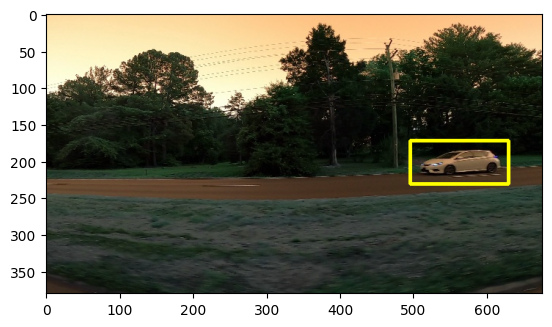

In [ ]:
DIR = '/content/drive/MyDrive/Selected-4/CarDataset/data/training_images/'
row = dict(data.iloc[3])
img = cv2.imread(DIR + row['image'])
print('Image Shape:', img.shape)
xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 0), 3)
plt.imshow(img)

###Convert CSV/annotations file to COCO

In [ ]:
def image(row):
    image = {}
    img = cv2.imread(DIR + row.image)
    image["height"] = img.shape[0]
    image["width"] = img.shape[1]
    image["id"] = row.fileid
    image["file_name"] = row.image
    return image

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax-row.xmin, row.ymax-row.ymin]
    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

In [ ]:
train_json_path = 'train_coco.json'
val_json_path = 'val_coco.json'

categories = []
train_images = []
train_annotations = []
val_images = []
val_annotations = []

In [ ]:
# dataset only has a single category, car

category = {}
category["supercategory"] = 'none'
category["id"] = 1
category["name"] = 'car'
categories.append(category)

In [ ]:
data['fileid'] = data['image'].astype('category').cat.codes
data['categoryid']= 1
data['annid'] = data.index
data.head()

,image,xmin,ymin,xmax,ymax,fileid,categoryid,annid
0,vid_4_1000.jpg,281,187,327,223,0,1,0
1,vid_4_10000.jpg,15,187,120,236,1,1,1
2,vid_4_10040.jpg,239,176,361,236,3,1,2
3,vid_4_10020.jpg,496,172,630,231,2,1,3
4,vid_4_10060.jpg,16,186,132,238,4,1,4


In [ ]:
train_val_imgs = glob.glob('/content/drive/MyDrive/Selected-4/CarDataset/data/training_images/*')
train_val_imgs = list(map(fname, train_val_imgs))
random.shuffle(train_val_imgs)
val_imgs = train_val_imgs[:50]
train_imgs = train_val_imgs[50:]
print('Training Size:', len(train_imgs))
print('Validation Size:', len(val_imgs))

Training Size: 951

Validation Size: 50

In [ ]:
for row in data.itertuples():
    if row.image in val_imgs:
        val_annotations.append(annotation(row))
    else:
        train_annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    if row.image in val_imgs:
        val_images.append(image(row))
    else:
        train_images.append(image(row))

train_data_coco = {}
train_data_coco["images"] = train_images
train_data_coco["categories"] = categories
train_data_coco["annotations"] = train_annotations
json.dump(train_data_coco, open(train_json_path, "w"), indent=4)

val_data_coco = {}
val_data_coco["images"] = val_images
val_data_coco["categories"] = categories
val_data_coco["annotations"] = val_annotations
json.dump(val_data_coco, open(val_json_path, "w"), indent=4)

###Detection Transformer- DETR

In [ ]:
%cd /content/drive/MyDrive/Selected-4/
!mkdir Facebook-DETR
if not os.path.exists(os.path.join("/content/drive/MyDrive/Selected-4/Facebook-DETR" ,'detr')):
    %cd /content/drive/MyDrive/Selected-4/Facebook-DETR
    !git clone https://github.com/sizhky/detr/

/content/drive/MyDrive/Selected-4
/content/drive/MyDrive/Selected-4/Facebook-DETR
Cloning into 'detr'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 12.88 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [ ]:
# moving files to desired folder structure

%cd /content/drive/MyDrive/Selected-4/Facebook-DETR/detr
!mkdir annotations
!mv /content/train_coco.json ./annotations/instances_train2017.json
!mv /content/val_coco.json ./annotations/instances_val2017.json
!ln -s /content/drive/MyDrive/Selected-4/CarDataset/data/training_images/ train2017
!ln -s /content/drive/MyDrive/Selected-4/CarDataset/data/training_images/ val2017

/content/drive/MyDrive/Selected-4/Facebook-DETR/detr


In [ ]:
# To load pre-trained weights

if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth 
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

--2023-05-01 02:16:13--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.29, 13.35.8.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M  53.1MB/s    in 3.0s    

2023-05-01 02:16:16 (53.1 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [ ]:
!python main.py --coco_path . --nclasses=1\
  --epochs 20 --lr=1e-4 --batch_size=6 --num_workers=1\
  --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Not using distributed mode
git:
  sha: 80281780ef5f1316378a5d760e78db20a72101c1, status: clean, branch: master

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=6, weight_decay=0.0001, epochs=20, lr_drop=200, clip_max_norm=0.1, nclasses=1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='.', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=1, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprec

###Evaluation & Testing

In [16]:
# Load model from torch.hub and load the checkpoints file into the model

TRAINED_CKPT_PATH = '/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/outputs/checkpoint.pth'
checkpoint = torch.load(TRAINED_CKPT_PATH, map_location='cpu')
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=2)
model.load_state_dict(checkpoint['model'], strict=False)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


<All keys matched successfully>

In [17]:
path_to_module = '/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util'
sys.path.append(path_to_module)

/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


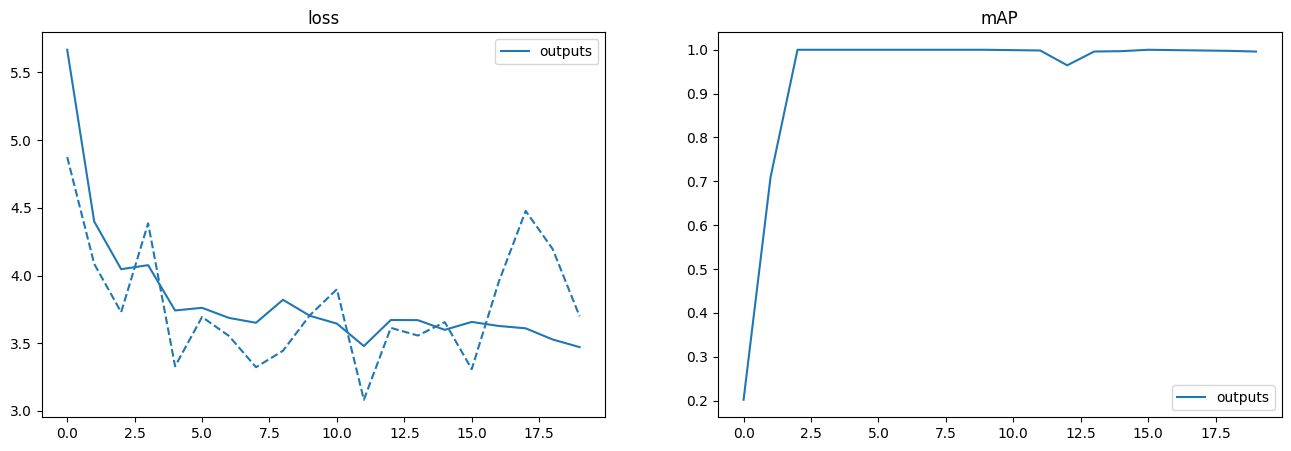

In [18]:
from plot_utils import plot_logs

log_directory = [Path('/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/outputs')]

fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory, fields_of_interest)

/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling t

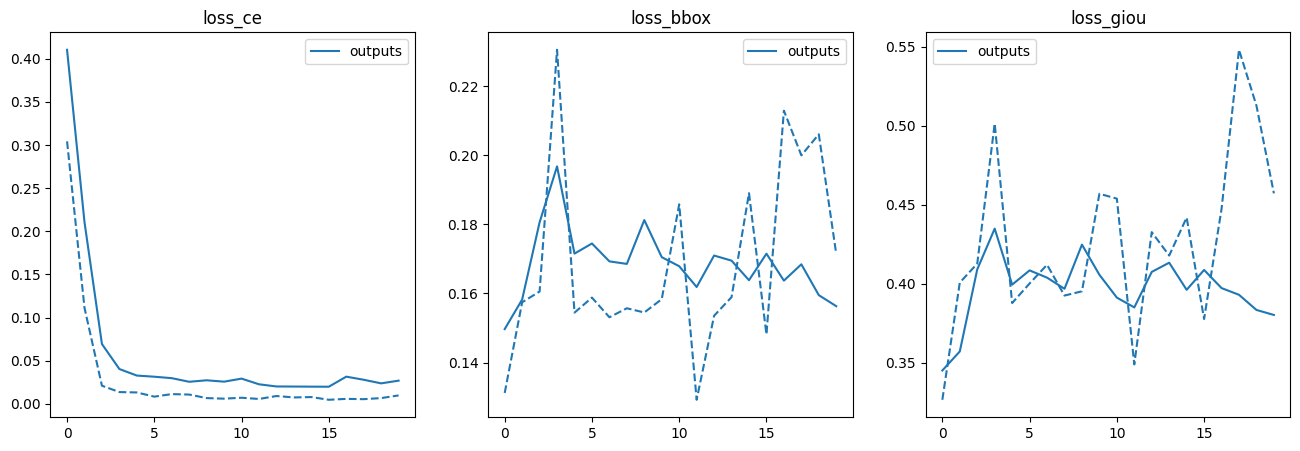

In [19]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/Selected-4/Facebook-DETR/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


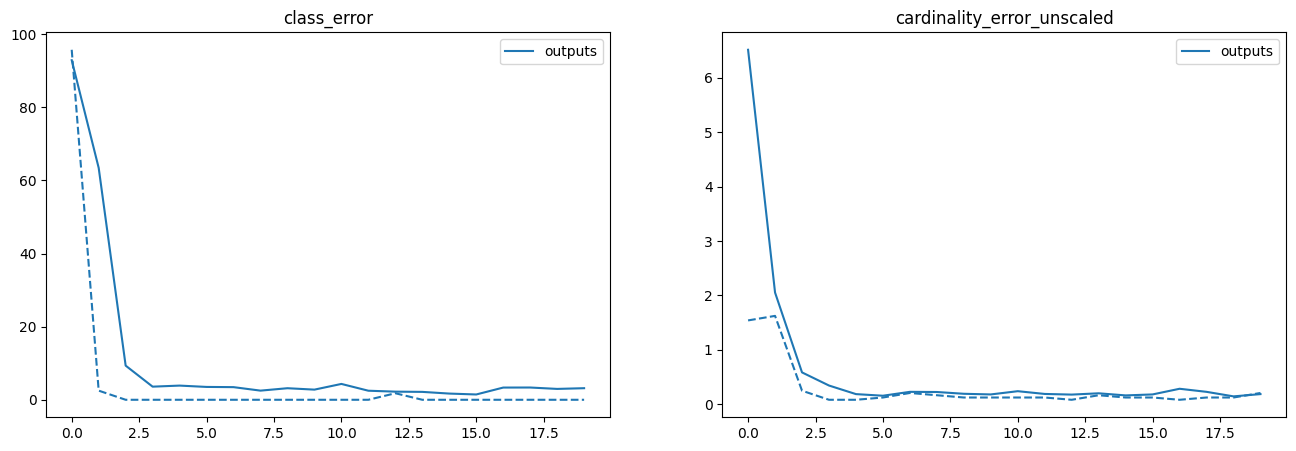

In [20]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

In [21]:
COLORS = [[0.000, 0.447, 0.741]]

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
def process_bbox(bbox):
    x_c, y_c, w, h = bbox.unbind(1)
    new_bbox = [(x_c - 0.5 * w), (y_c - 0.5 * h),
                (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(new_bbox, dim=1)

def rescale_bboxes(bbox, size):
    img_w, img_h = size
    new_bbox = process_bbox(bbox)
    new_bbox *= torch.tensor([img_w, img_h, img_w, img_h],
                              dtype=torch.float32)
    return new_bbox
    
def detect(im, model, transform, thres=0.7):
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probs = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probs.max(-1).values > thres
    # convert boxes from [0, 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probs[keep], bboxes_scaled

def plot_results(path_img, prob, boxes, figsize=(16, 10)):
    plt.figure(figsize=figsize)
    img = cv2.imread(path_img)
    img = cv2.resize(img, (800, 800))
    font = cv2.FONT_HERSHEY_PLAIN
    for prob, (xmin, ymin, xmax, ymax), col in \
        zip(prob, boxes.tolist(), COLORS * 100):
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 0), 3)
        cl = prob.argmax()
        text = f'car: {prob[cl]:0.2f}'
        cv2.putText(img, text, (xmin, ymin-20), font, 2, 
                    (255, 255, 255), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

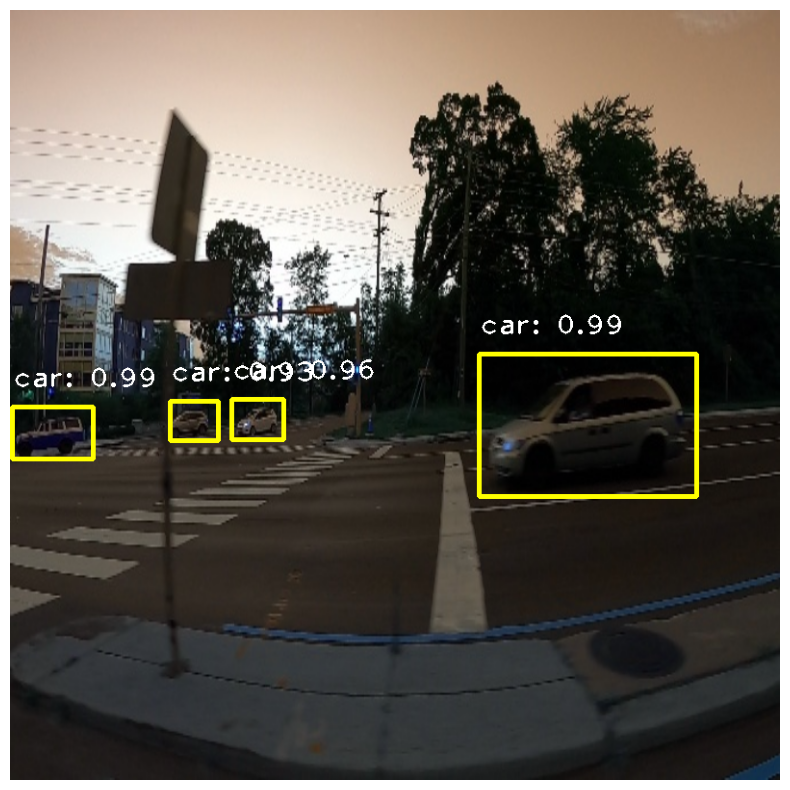

Duration (seconds): 8.94950

In [23]:
start_time = time.time()
img_path = '/content/drive/MyDrive/Selected-4/CarDataset/data/testing_images/vid_5_27480.jpg'
img = Image.open(img_path)
img = img.resize((800,800)).convert('RGB')
scores, boxes = detect(img, model, transform)
plot_results(img_path, scores, boxes)
print(f'Duration (seconds): {time.time() - start_time:.5f}')

### Thank You..!
